In [ ]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import dataset

In [2]:
MAXLEN = 60
BATCH_SIZE = 64
files = ['texts/' + f for f in os.listdir('texts/')]

data = dataset.load_file(BATCH_SIZE, 0.05, maxlen=MAXLEN, filenames=files)

In [3]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 512
UNITS = 512

inp = tf.keras.Input(batch_shape=(None, data.input_texts.shape[1]), batch_size=BATCH_SIZE)

embedding = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)

rnn_common = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.5), merge_mode='sum', name='Common_RNN')(embedding)

rnn_niqqud = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum', name='Niqqud_RNN')(rnn_common)

dense_1 = layers.Dense(UNITS, activation='relu', kernel_regularizer=l2(5e-5), kernel_initializer='he_uniform')(rnn_niqqud)

add = layers.add([rnn_common, dense_1])

norm_1 = layers.BatchNormalization()(add)

output_niqqud = layers.Dense(data.niqqud_texts.shape[1], name='N_raw')(norm_1)
output_niqqud = layers.Softmax(name='N')(output_niqqud)

rnn_dagesh = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.2), merge_mode='sum', name='Dagesh_RNN')(rnn_common) 

output_dagesh = layers.Dense(data.dagesh_texts.shape[1], name='D_raw', kernel_initializer='he_uniform')(rnn_dagesh)
output_dagesh = layers.Softmax(name='D')(output_dagesh)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])

plot_model(model, to_file='model.png')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 512)      38400       input_1[0][0]                    
__________________________________________________________________________________________________
Common_RNN (Bidirectional)      (None, 60, 512)      3151872     embedding[0][0]                  
__________________________________________________________________________________________________
Niqqud_RNN (Bidirectional)      (None, 60, 512)      3151872     Common_RNN[0][0]                 
______________________________________________________________________________________________

In [4]:
def schedule(epoch, lr):
    return [0.002, 0.0003][epoch]

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

In [5]:
history = fit(EPOCHS=2)

Train on 115337 samples, validate on 6071 samples
Epoch 1/2
115337/115337 [==============================] - 242s 2ms/sample - loss: 0.3387 - N_loss: 0.2387 - D_loss: 0.0738 - N_accuracy: 0.9187 - D_accuracy: 0.9726 - val_loss: 0.1803 - val_N_loss: 0.1288 - val_D_loss: 0.0342 - val_N_accuracy: 0.9573 - val_D_accuracy: 0.9870
Epoch 2/2
115337/115337 [==============================] - 231s 2ms/sample - loss: 0.1366 - N_loss: 0.0936 - D_loss: 0.0292 - N_accuracy: 0.9682 - D_accuracy: 0.9890 - val_loss: 0.1248 - val_N_loss: 0.0879 - val_D_loss: 0.0257 - val_N_accuracy: 0.9708 - val_D_accuracy: 0.9902


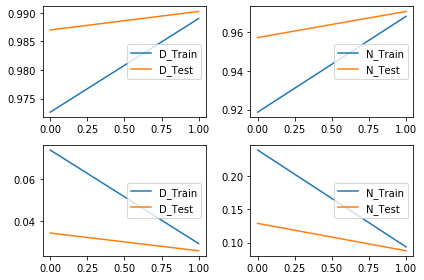

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [7]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = dataset.from_categorical(model.predict(batch))
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for a, e in zip(actual, expected):
        print(a)
        print(e)
        print()

print_predictions(1)

שֶנָּטַל הַחֹמֶץ; וְכֵן שְנֵי בָּתִּים בַּדּוּקִין, וְצִבּוּר אֶחָד חָמֵץ, וּבָא עַכְבָּר
שֶנָּטַל הֶחָמֵץ; וְכֵן שְנֵי בָּתִּים בְּדוּקִין, וְצִבּוּר אֶחָד חָמֵץ, וּבָא עַכְבָּר

וְדֶרֶךְ כָּל אָדָם לַעֲשוֹת אָז סֻכָּה לַצֵל וְלֹא הָיְתָה נִכֶּרֶת שֶהִיא בְּמִצְוַת הַבּוֹרֵא
וְדֶרֶךְ כָּל אָדָם לַעֲשוֹת אָז סֻכָּה לְצֵל וְלֹא הָיְתָה נִכֶּרֶת שֶהִיא בְּמִצְוַת הַבּוֹרֵא

וְאִם לֹא הָיוּ עוֹשִין מֵעֵין מְלַאכְתָּן, הֲרֵי הֶן כְּמוֹ שֶנִּגְנְבוּ אוֹ אָבְדוּ,
וְאִם לֹא הָיוּ עוֹשִין מֵעֵין מְלַאכְתָּן, הֲרֵי הֶן כְּמוֹ שֶנִּגְנְבוּ אוֹ אָבְדוּ,

מִשֶּיַּאֲרִיךְ הַצֵּל וְיִכָר לַכָל שֶהֶאֱרִיךְ, וְהוּא מִשֵּש שָעוֹת וּמֶחְצָה וָמַעְלָה, עַד
מִשֶּיַּאֲרִיךְ הַצֵּל וְיֻכַּר לַכֹּל שֶהֶאֱרִיךְ, וְהוּא מִשֵּש שָעוֹת וּמֶחְצָה וָמַעְלָה, עַד

אֶת הַקֶּמַח לְתוֹךְ הַחַרְדָּל; וְאִם נָתַן, יֵאכַל מִיָּד. מֻתָּר לָתֵת הַתְּבָלִין
אֶת הַקֶּמַח לְתוֹךְ הַחַרְדָּל; וְאִם נָתַן, יֹאכַל מִיָּד. מֻתָּר לָתֵת הַתְּבָלִין

וְלֹא-תֵסֵב נַחֲלָה לִבְנֵי יִשְרָאֵל מִמַּטֵּה אֶל-מַטֵּה כִּי אִיש בְּנַחֲלַת מַ